In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from pylab import rcParams
import statsmodels.api as sm
import itertools

In [ ]:
# Load data
data = pd.read_csv('/content/MarketPricePrediction.csv')

In [ ]:
data.describe()

,year,quantity,priceMin,priceMax,priceMod
count,10227.000000,1.022700e+04,10227.000000,10227.000000,10227.000000
mean,2009.022294,7.660488e+04,646.944363,1212.760731,984.284345
std,4.372841,1.244087e+05,673.121850,979.658874,818.471498
min,1996.000000,2.000000e+01,16.000000,145.000000,80.000000
25%,2006.000000,8.898000e+03,209.000000,557.000000,448.000000
50%,2009.000000,2.746000e+04,440.000000,923.000000,747.000000
75%,2013.000000,8.835650e+04,828.000000,1527.000000,1248.000000
max,2016.000000,1.639032e+06,6000.000000,8192.000000,6400.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10227 entries, 0 to 10226
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
 9   date      10227 non-null  object
dtypes: int64(5), object(5)
memory usage: 799.1+ KB


In [ ]:
data.fillna(method='ffill', inplace=True)

In [ ]:
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Step 2: Convert month names to numeric values
data['month'] = data['month'].map(month_mapping)

In [ ]:
# # Combine date columns
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

In [ ]:
# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['market', 'state', 'city'])

In [ ]:
data.columns

Index(['market', 'month', 'year', 'quantity', 'priceMin', 'priceMax',
       'priceMod', 'state', 'city', 'date'],
      dtype='object')

In [ ]:
data.sort_values(by='date', ascending = True, inplace = True)

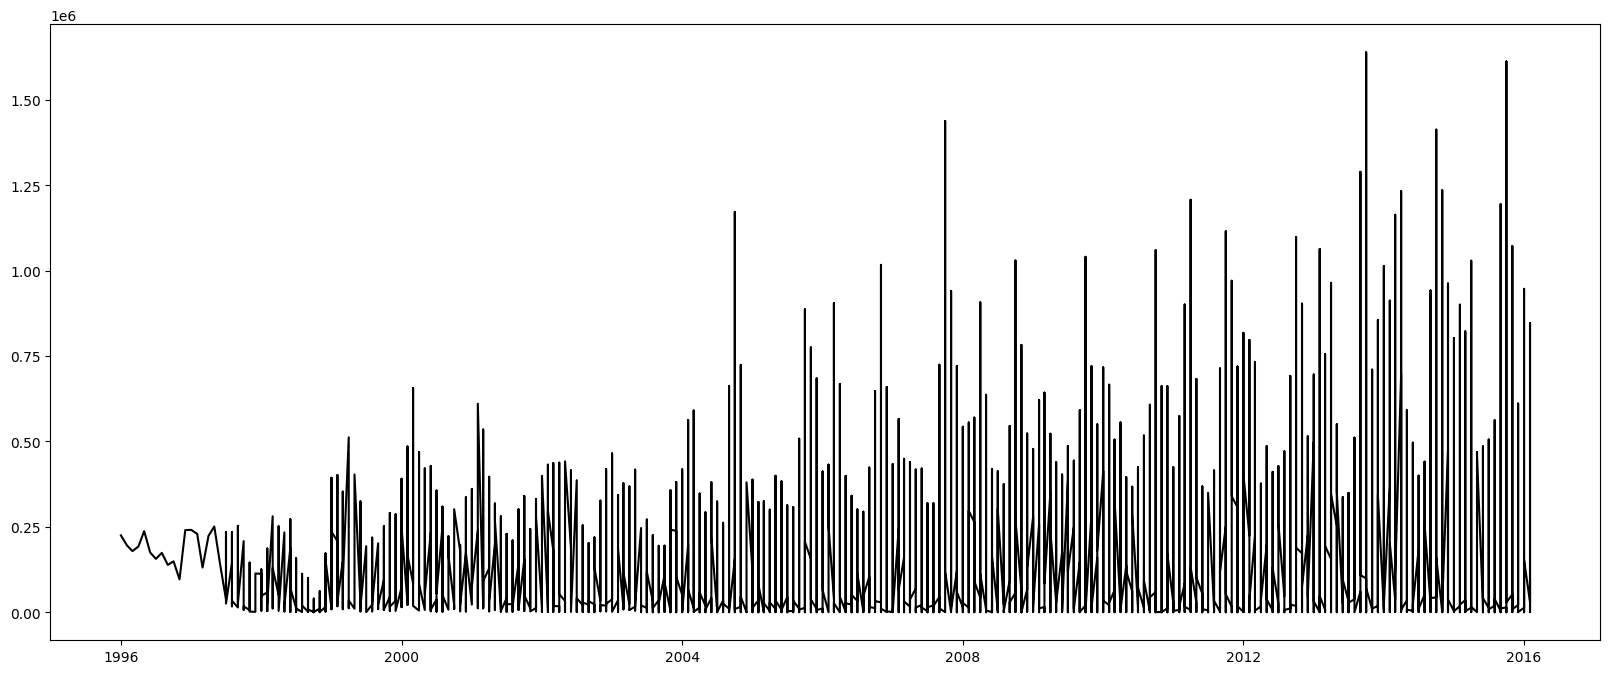

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data['date'], data['quantity'], color='black')

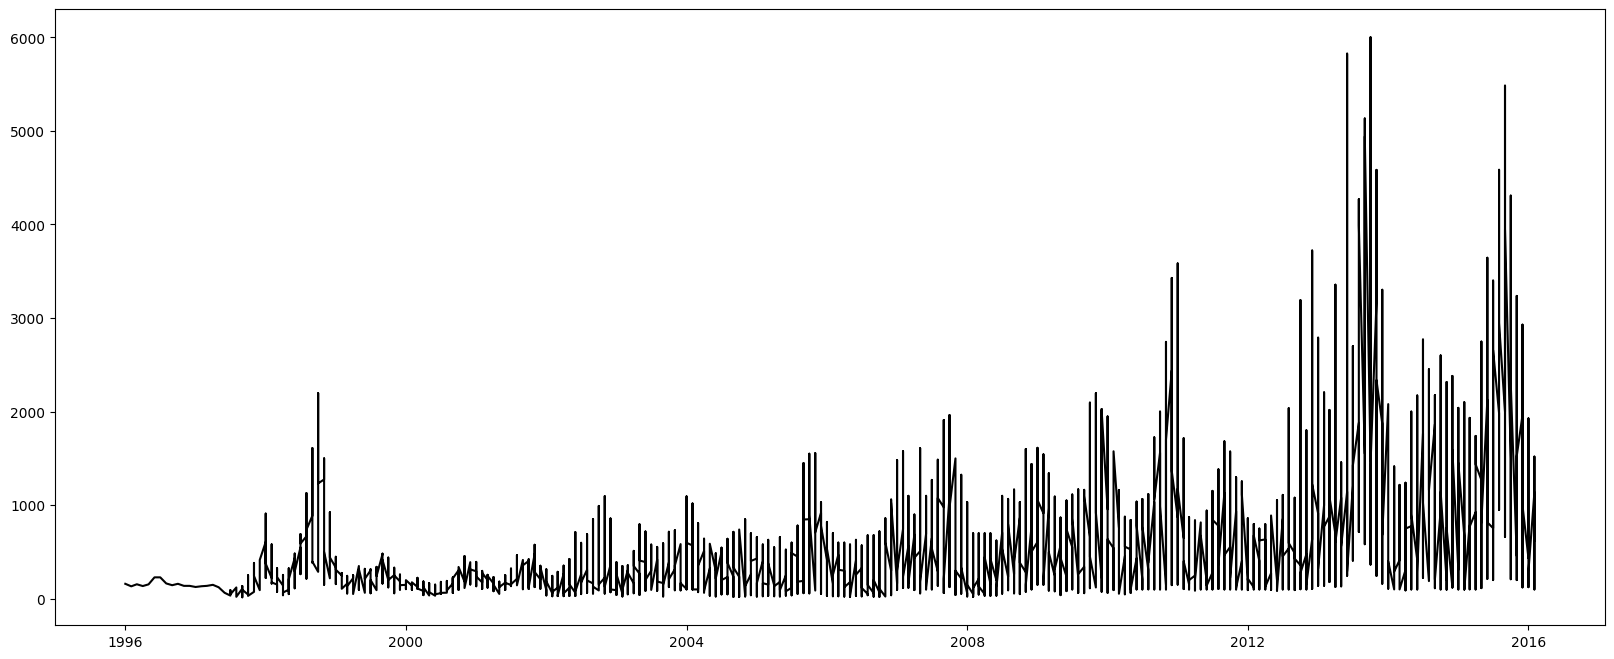

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data['date'], data['priceMin'], color='black')

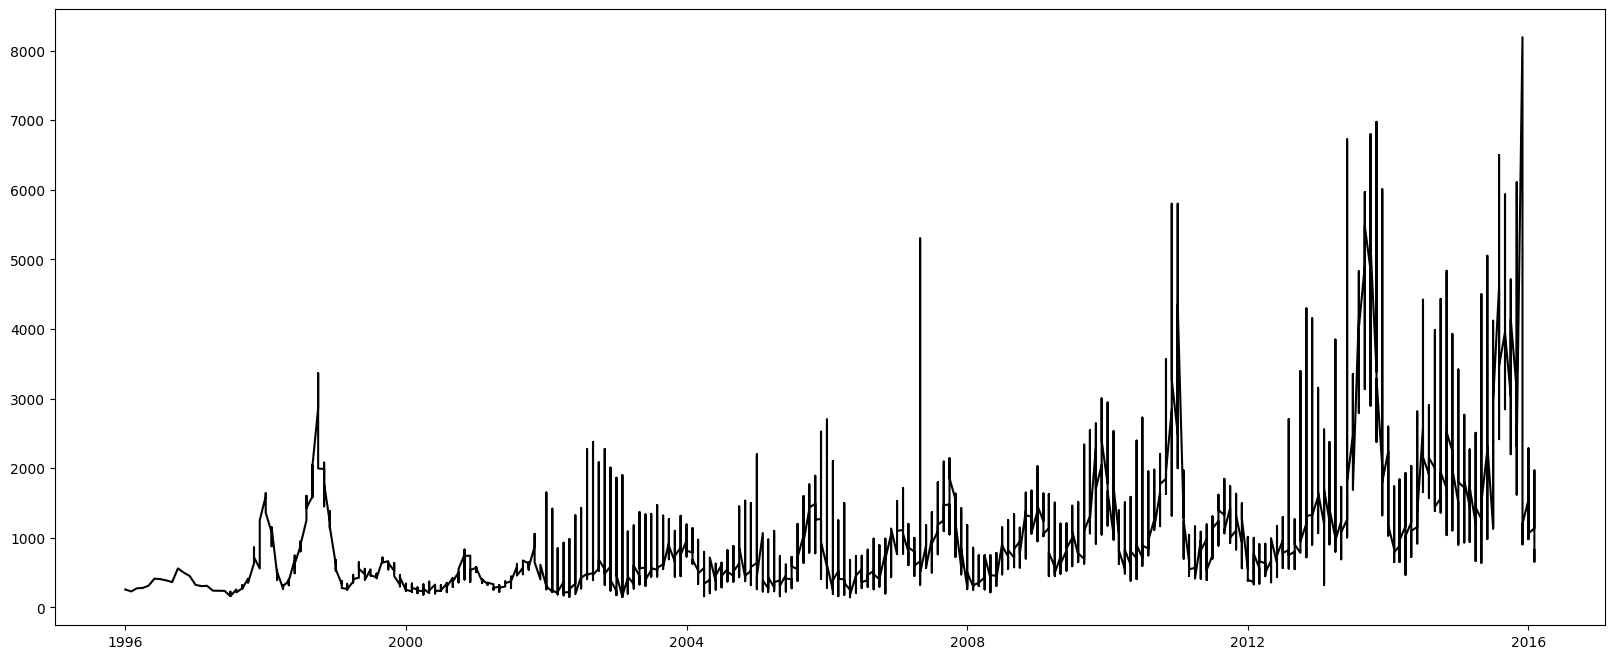

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data['date'], data['priceMax'], color='black')

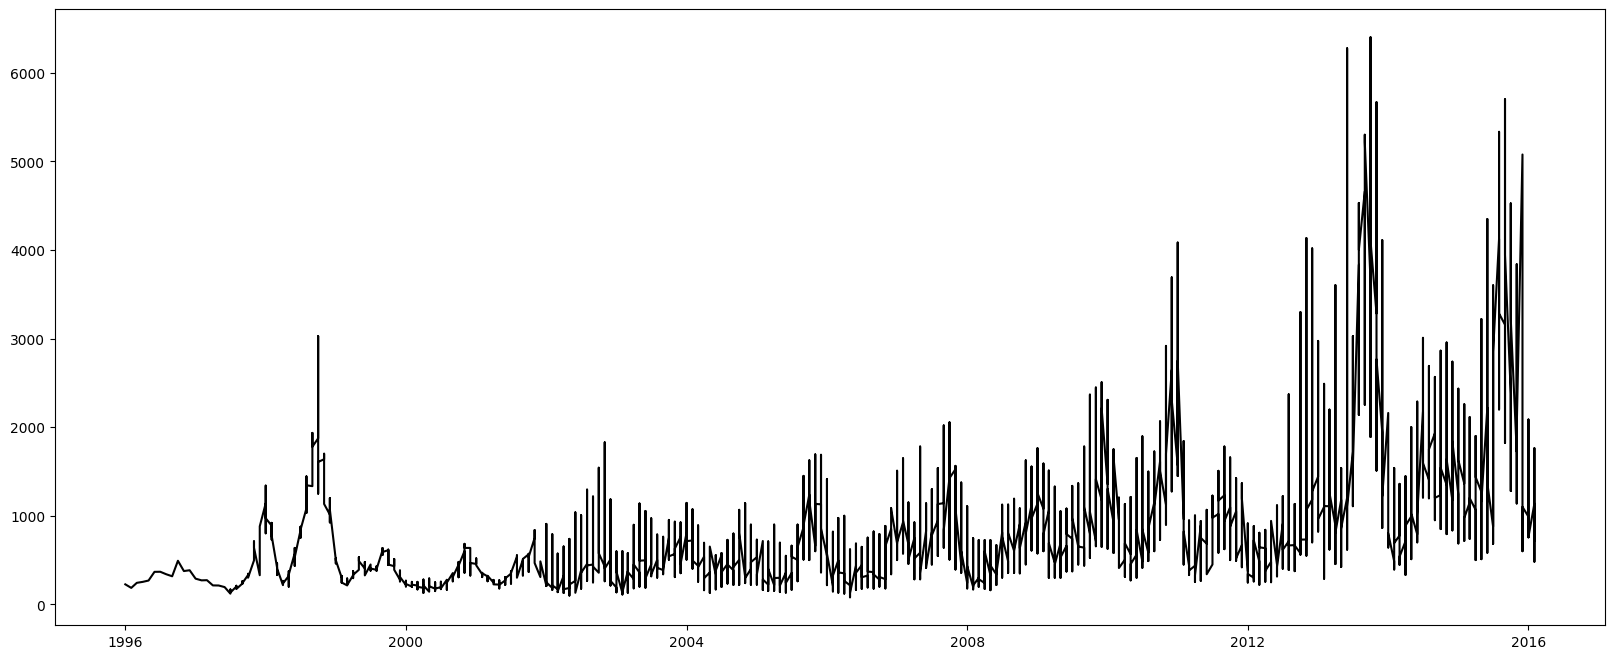

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data['date'], data['priceMod'], color='black')

In [ ]:
data['date']

5399    1996-01-01
5420    1996-02-01
5441    1996-03-01
5461    1996-04-01
5481    1996-05-01
           ...    
8226    2016-02-01
3644    2016-02-01
10106   2016-02-01
8962    2016-02-01
5096    2016-02-01
Name: date, Length: 10227, dtype: datetime64[ns]

In [ ]:
# data.set_index('date', inplace=True)

In [ ]:
data = data.set_index('date')
data.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2016-02-01', '2016-02-01', '2016-02-01', '2016-02-01',
               '2016-02-01', '2016-02-01', '2016-02-01', '2016-02-01',
               '2016-02-01', '2016-02-01'],
              dtype='datetime64[ns]', name='date', length=10227, freq=None)

#quantity

In [ ]:
y = data['quantity'].resample('MS').mean()

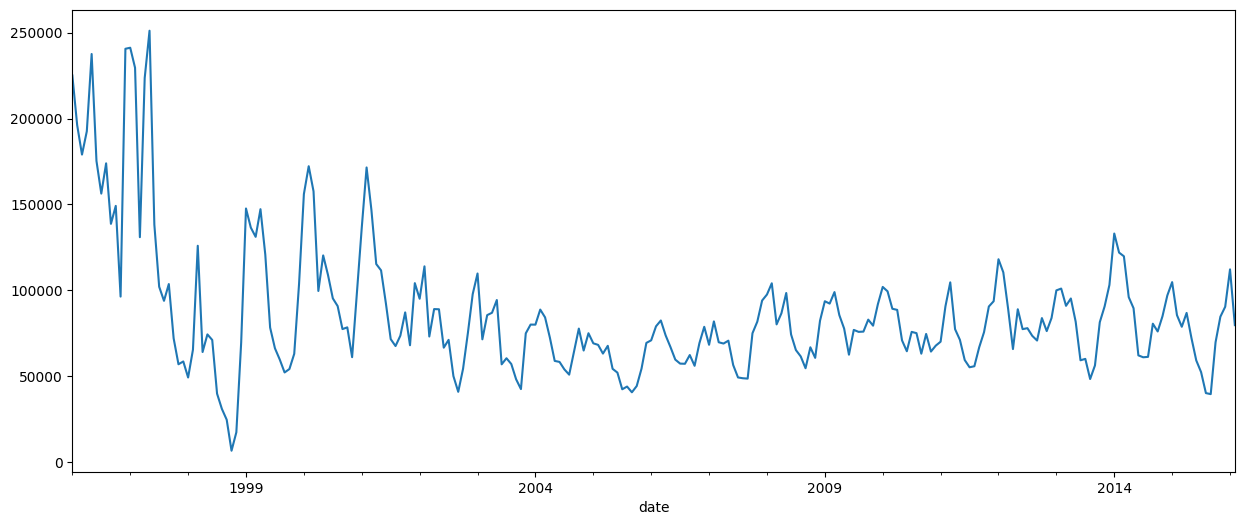

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

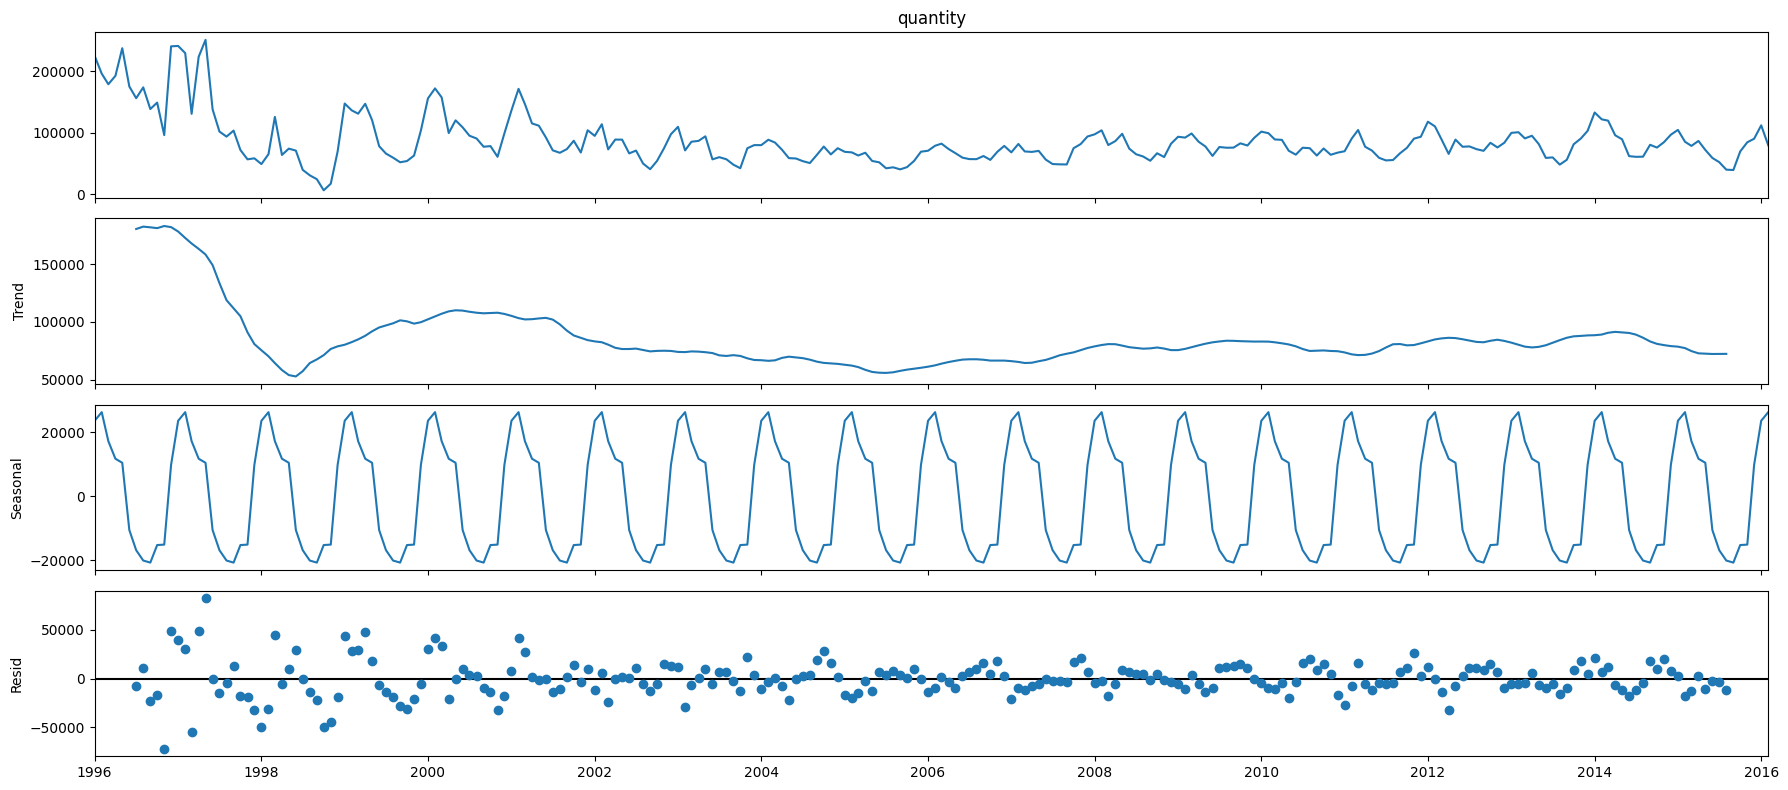

In [ ]:

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 18) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 18)
SARIMAX: (0, 0, 1) x (0, 1, 0, 18)
SARIMAX: (0, 1, 0) x (0, 1, 1, 18)
SARIMAX: (0, 1, 0) x (1, 0, 0, 18)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 18)12 - AIC:3814.4491989656344
ARIMA(0, 0, 0)x(0, 0, 1, 18)12 - AIC:3484.915075942329
ARIMA(0, 0, 0)x(0, 1, 0, 18)12 - AIC:3418.7284099782732
ARIMA(0, 0, 0)x(0, 1, 1, 18)12 - AIC:3079.2745483978447
ARIMA(0, 0, 0)x(1, 0, 0, 18)12 - AIC:3424.2364289884727
ARIMA(0, 0, 0)x(1, 0, 1, 18)12 - AIC:3302.541383530456
ARIMA(0, 0, 0)x(1, 1, 0, 18)12 - AIC:3073.300752288502
ARIMA(0, 0, 0)x(1, 1, 1, 18)12 - AIC:3060.452292491543
ARIMA(0, 0, 1)x(0, 0, 0, 18)12 - AIC:3513.0362372544496
ARIMA(0, 0, 1)x(0, 0, 1, 18)12 - AIC:3226.2539218666725
ARIMA(0, 0, 1)x(0, 1, 0, 18)12 - AIC:3194.8504654654325
ARIMA(0, 0, 1)x(0, 1, 1, 18)12 - AIC:2863.7911270227864
ARIMA(0, 0, 1)x(1, 0, 0, 18)12 - AIC:3204.518341074505
ARIMA(0, 0, 1)x(1, 0, 1, 18)12 - AIC:3085.715655938209
ARIMA(0, 0, 1)x(1, 1, 0, 18)12 - AIC:2863.850731530336
ARIMA(0, 0, 1)x(1, 1, 1, 18)12 - AIC:2838.2939409642436
ARIMA(0, 1, 0)x(0, 0, 0, 18)12 - AIC:3197.777793679822
ARIMA(0, 1, 0)x(0, 0, 1, 18)12 - AIC:2974.7083181920434


In [ ]:
# ARIMA(0, 1, 1)x(1, 1, 1, 18)12 - AIC:2703.939333820689

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 18),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4730      0.050      9.383      0.000       0.374       0.572
ar.S.L18      -0.0690      0.108     -0.639      0.523      -0.281       0.143
ma.S.L18      -1.0000      0.044    -22.489      0.000      -1.087      -0.913
sigma2      2.907e+04   1.53e-06    1.9e+10      0.000    2.91e+04    2.91e+04


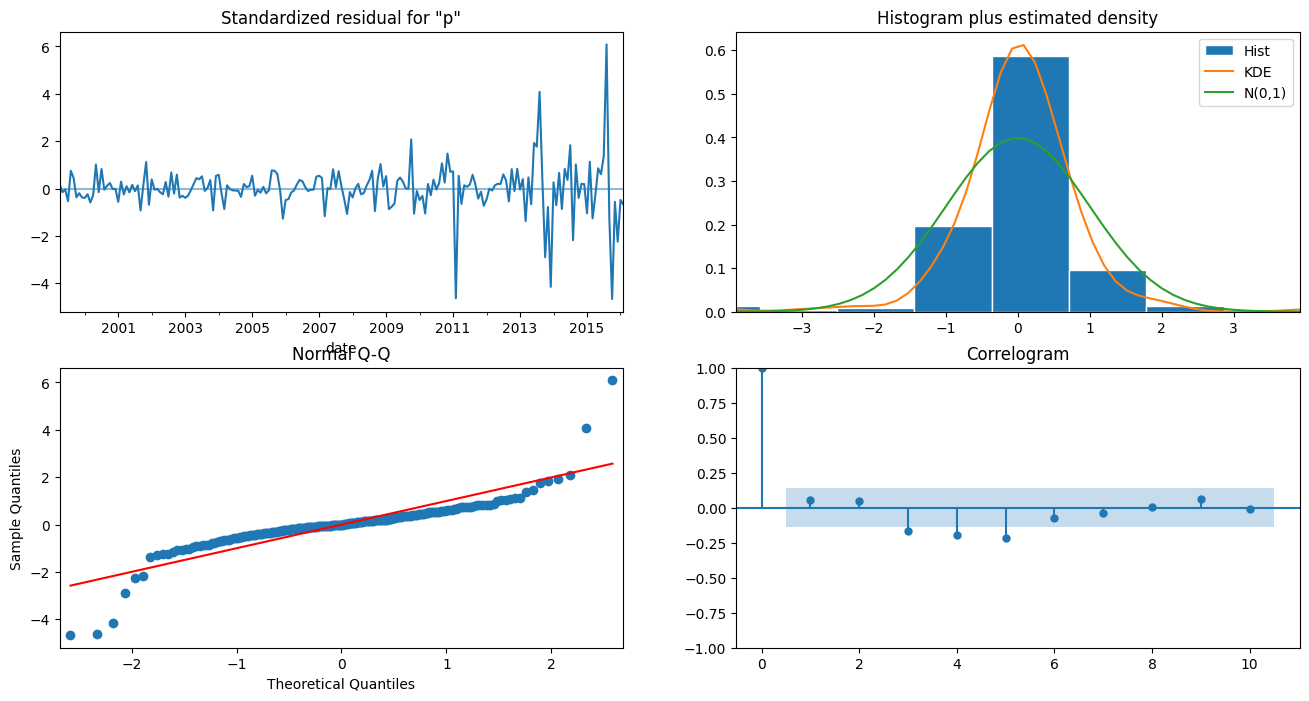

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

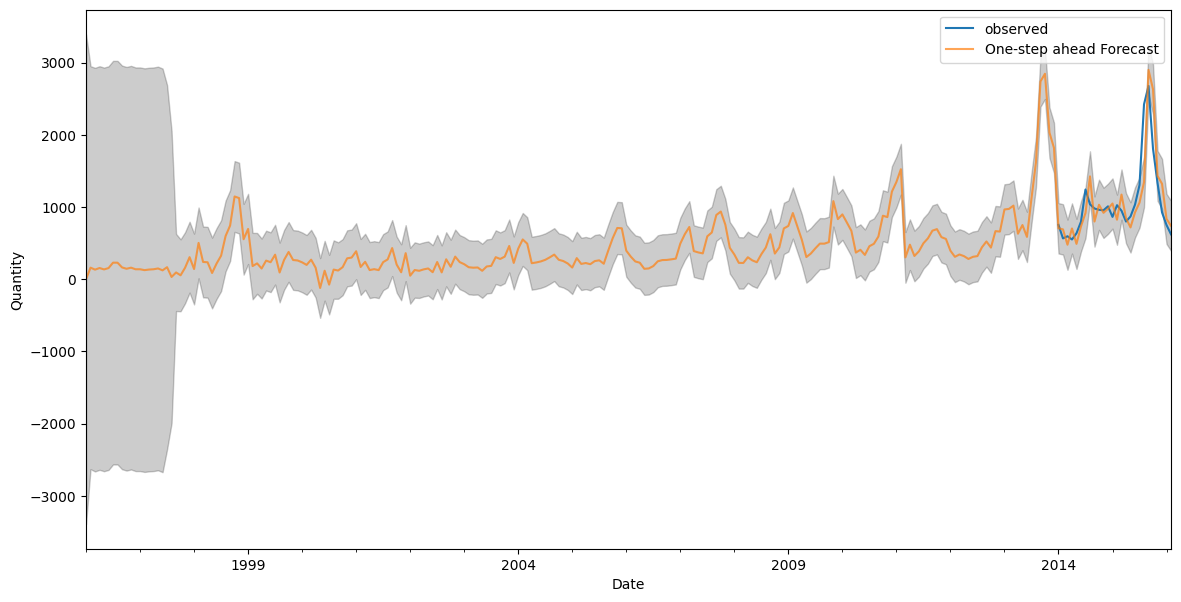

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1996-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['1996-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 29414.36


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 171.51


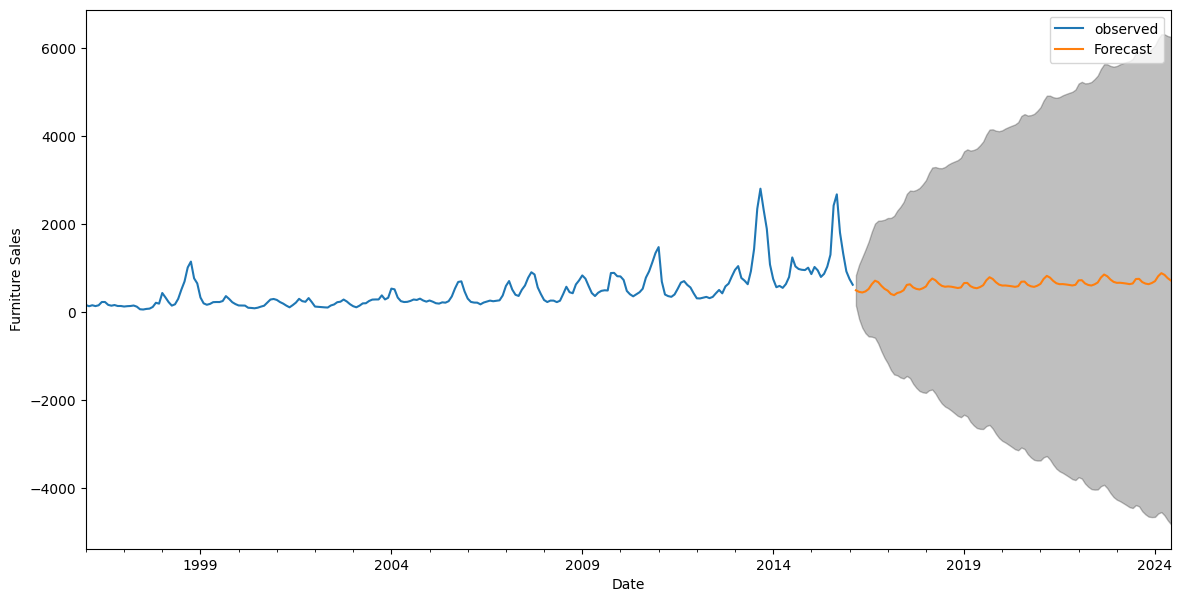

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

#priceMin

In [ ]:
y = data['priceMin'].resample('MS').mean()

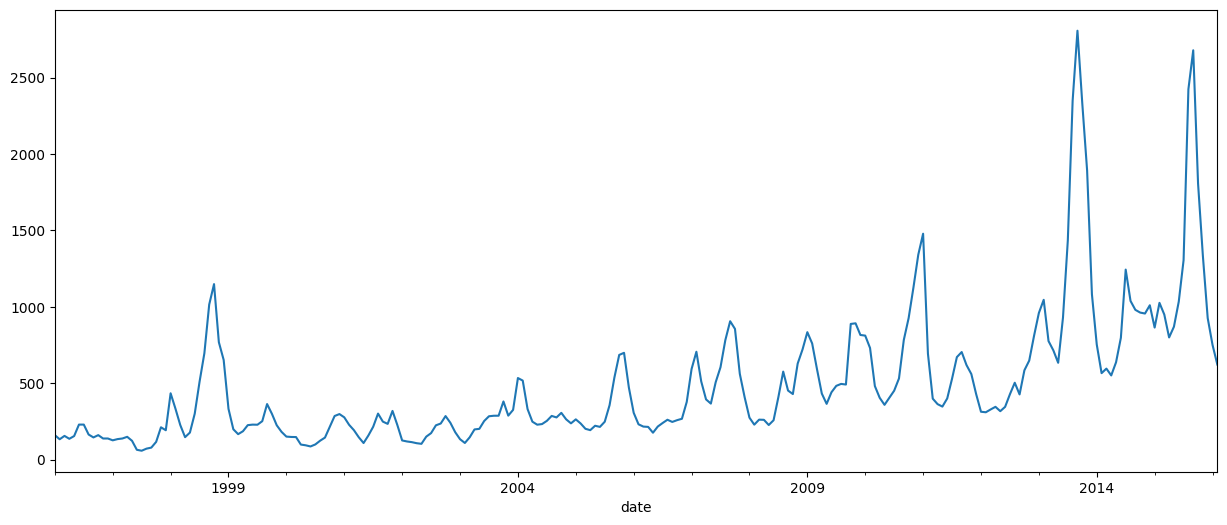

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

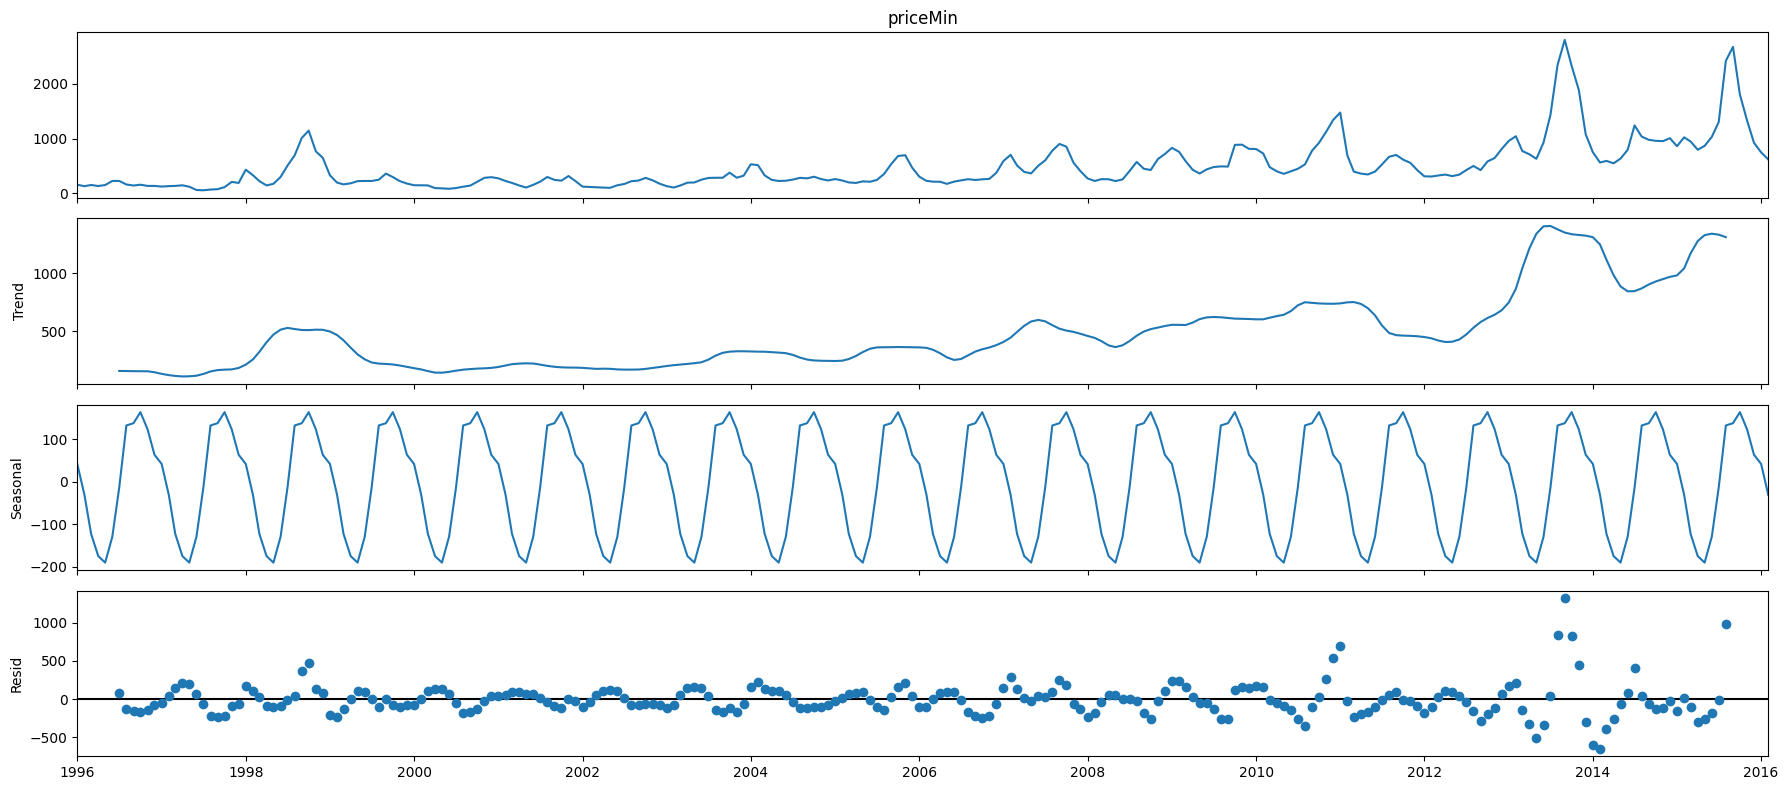

In [ ]:

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3814.4491989656344
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3566.188956914637
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3449.1239198017197
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3187.91731863772
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3457.794569692177
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3306.733747562723
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3174.7776648260324
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3157.5587037171554
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3513.0362372544496
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3297.42415091371
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3239.226827097331
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2975.6906876071075
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3251.672950758013
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3096.1910194755555
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2983.1009575456633
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2946.9678395702067
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3197.777793679822
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3051.2114900177858
AR

In [ ]:
#ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2804.884512093772
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4183      0.066      6.301      0.000       0.288       0.548
ar.S.L12      -0.5701      0.043    -13.303      0.000      -0.654      -0.486
ma.S.L12      -0.5392      0.055     -9.893      0.000      -0.646      -0.432
sigma2      2.579e+04   1316.505     19.592      0.000    2.32e+04    2.84e+04


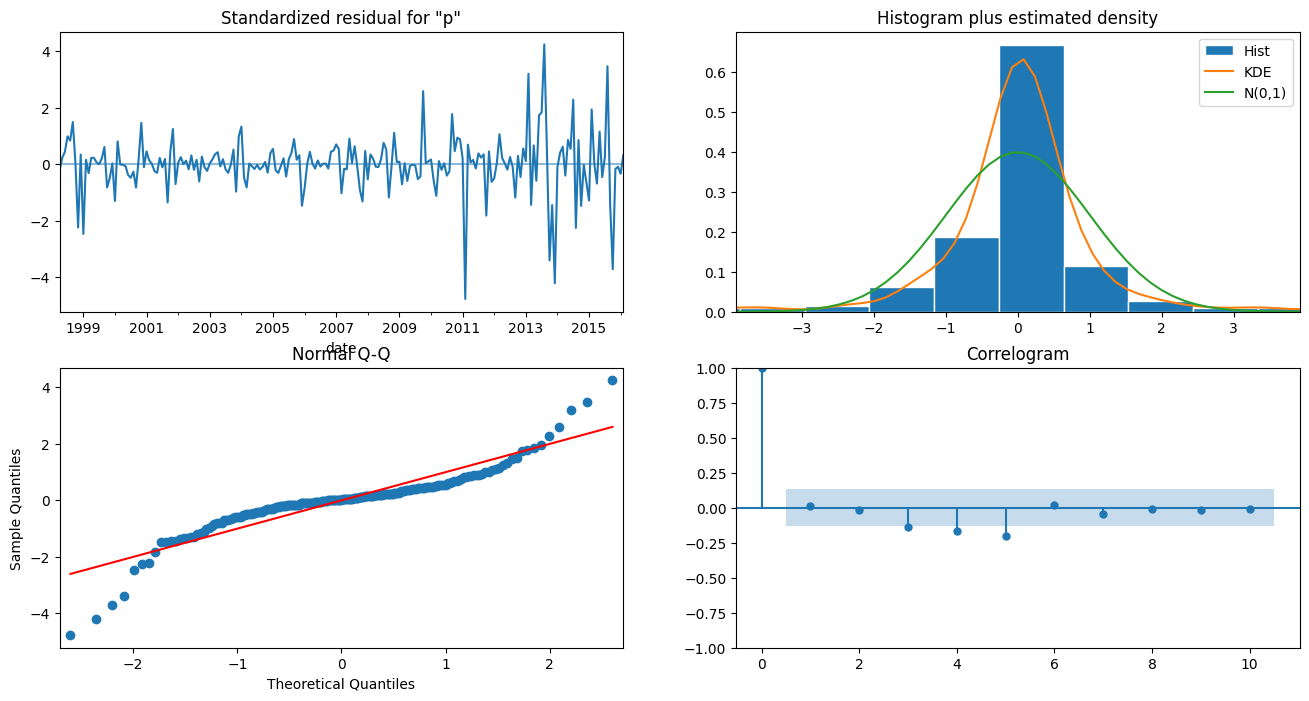

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

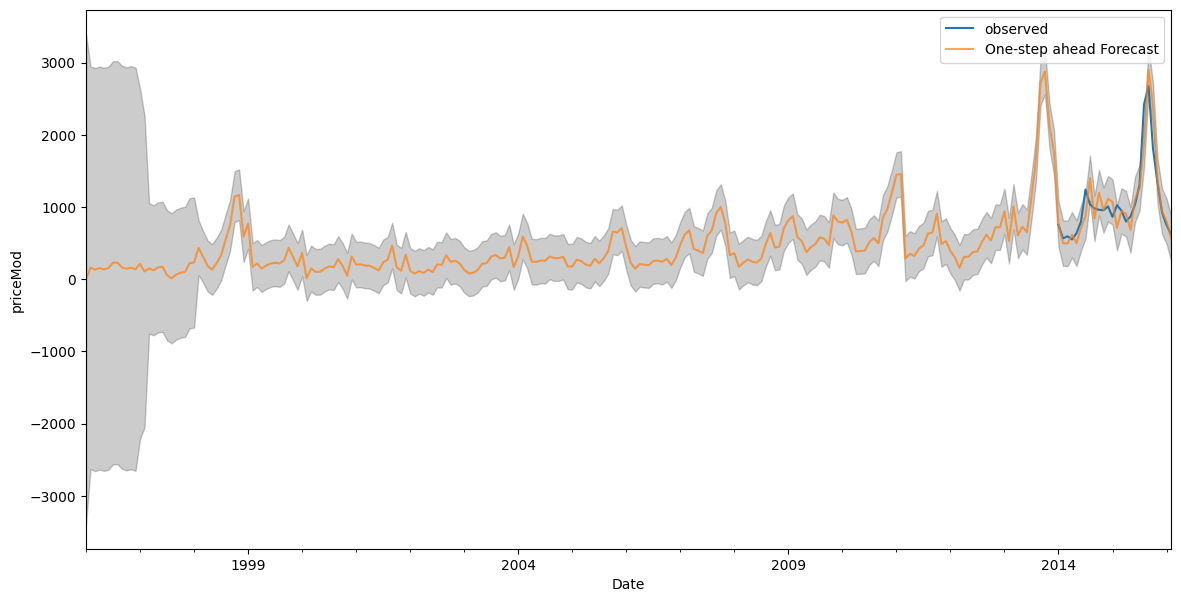

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1996-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('priceMod')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['1996-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 23866.11


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 154.49


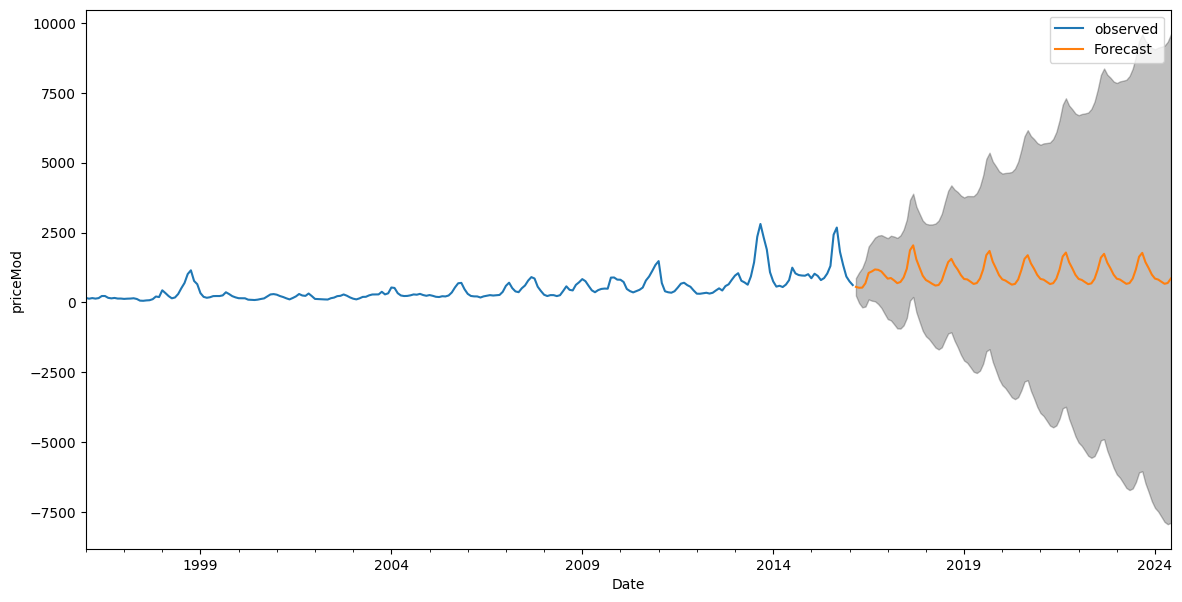

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('priceMod')
plt.legend()
plt.show()

#priceMax

In [ ]:
y = data['priceMax'].resample('MS').mean()

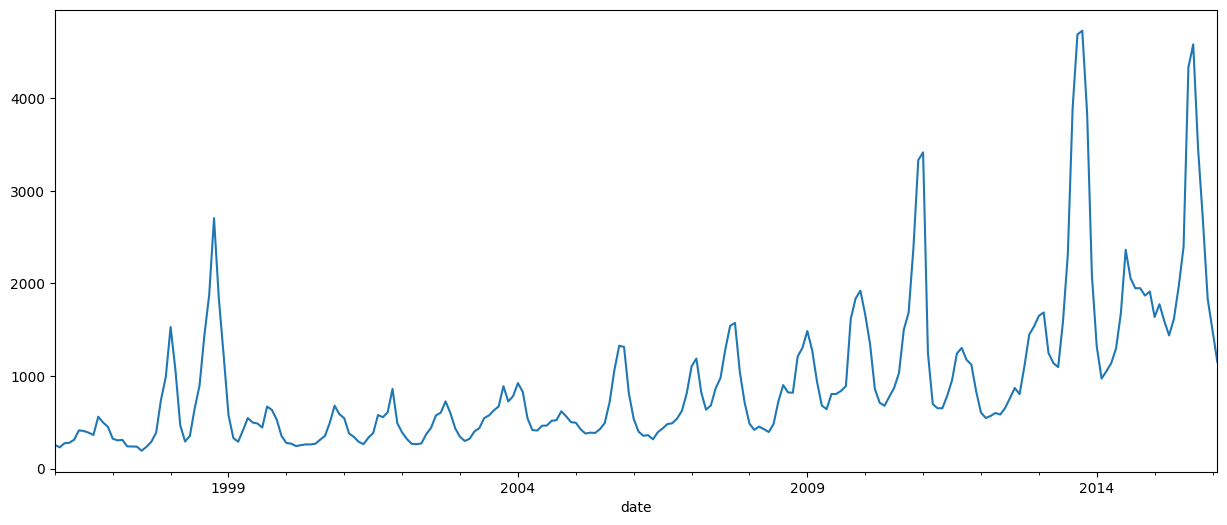

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

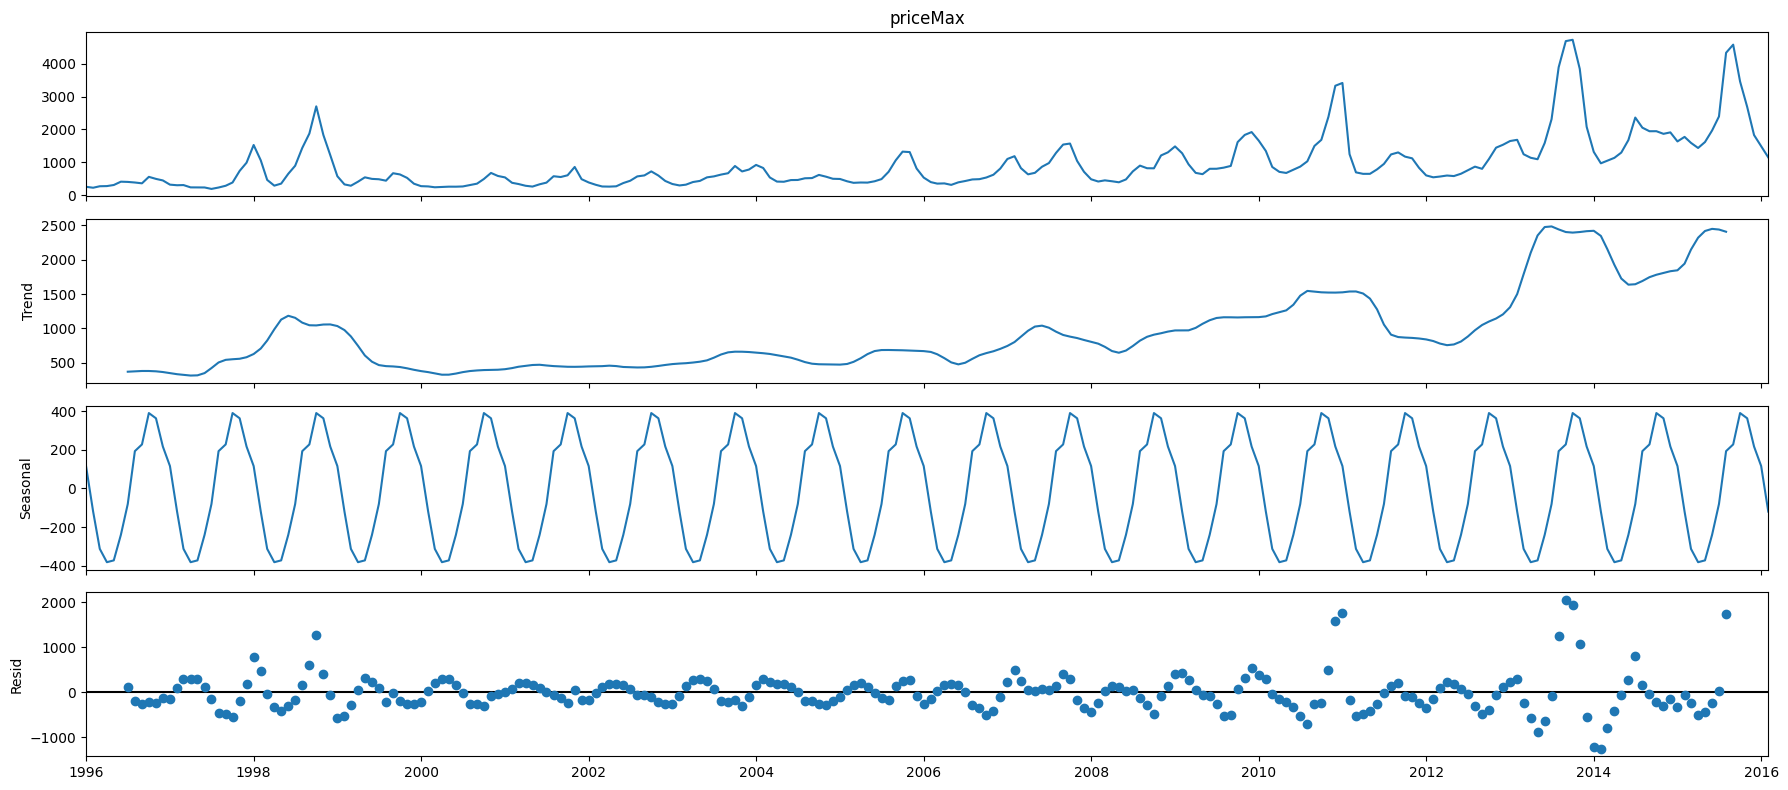

In [ ]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 15) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 15)
SARIMAX: (0, 0, 1) x (0, 1, 0, 15)
SARIMAX: (0, 1, 0) x (0, 1, 1, 15)
SARIMAX: (0, 1, 0) x (1, 0, 0, 15)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 15)12 - AIC:4122.74533096293
ARIMA(0, 0, 0)x(0, 0, 1, 15)12 - AIC:3793.4000403725126
ARIMA(0, 0, 0)x(0, 1, 0, 15)12 - AIC:3736.0032998291554
ARIMA(0, 0, 0)x(0, 1, 1, 15)12 - AIC:3433.5642504675284
ARIMA(0, 0, 0)x(1, 0, 0, 15)12 - AIC:3741.430461127664
ARIMA(0, 0, 0)x(1, 0, 1, 15)12 - AIC:3625.764255580002
ARIMA(0, 0, 0)x(1, 1, 0, 15)12 - AIC:3470.81823339452
ARIMA(0, 0, 0)x(1, 1, 1, 15)12 - AIC:3433.0519460871574
ARIMA(0, 0, 1)x(0, 0, 0, 15)12 - AIC:3821.2395381987735
ARIMA(0, 0, 1)x(0, 0, 1, 15)12 - AIC:3524.3763686426864
ARIMA(0, 0, 1)x(0, 1, 0, 15)12 - AIC:3491.4752505833603
ARIMA(0, 0, 1)x(0, 1, 1, 15)12 - AIC:3203.037657366471
ARIMA(0, 0, 1)x(1, 0, 0, 15)12 - AIC:3504.626116663245
ARIMA(0, 0, 1)x(1, 0, 1, 15)12 - AIC:3403.5962124416906
ARIMA(0, 0, 1)x(1, 1, 0, 15)12 - AIC:3263.1283745496858
ARIMA(0, 0, 1)x(1, 1, 1, 15)12 - AIC:3204.2812109632832
ARIMA(0, 1, 0)x(0, 0, 0, 15)12 - AIC:3514.6542444293573
ARIMA(0, 1, 0)x(0, 0, 1, 15)12 - AIC:3310.9968994613655


In [ ]:
#ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:3097.555502068154
#ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:3094.014515648448
#ARIMA(1, 1, 1)x(0, 1, 1, 15)12 - AIC:3055.428246055786
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 15),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2671      0.090      2.984      0.003       0.092       0.443
ma.L1          0.2863      0.089      3.215      0.001       0.112       0.461
ma.S.L15      -0.9018      0.055    -16.286      0.000      -1.010      -0.793
sigma2      1.175e+05   5752.622     20.422      0.000    1.06e+05    1.29e+05


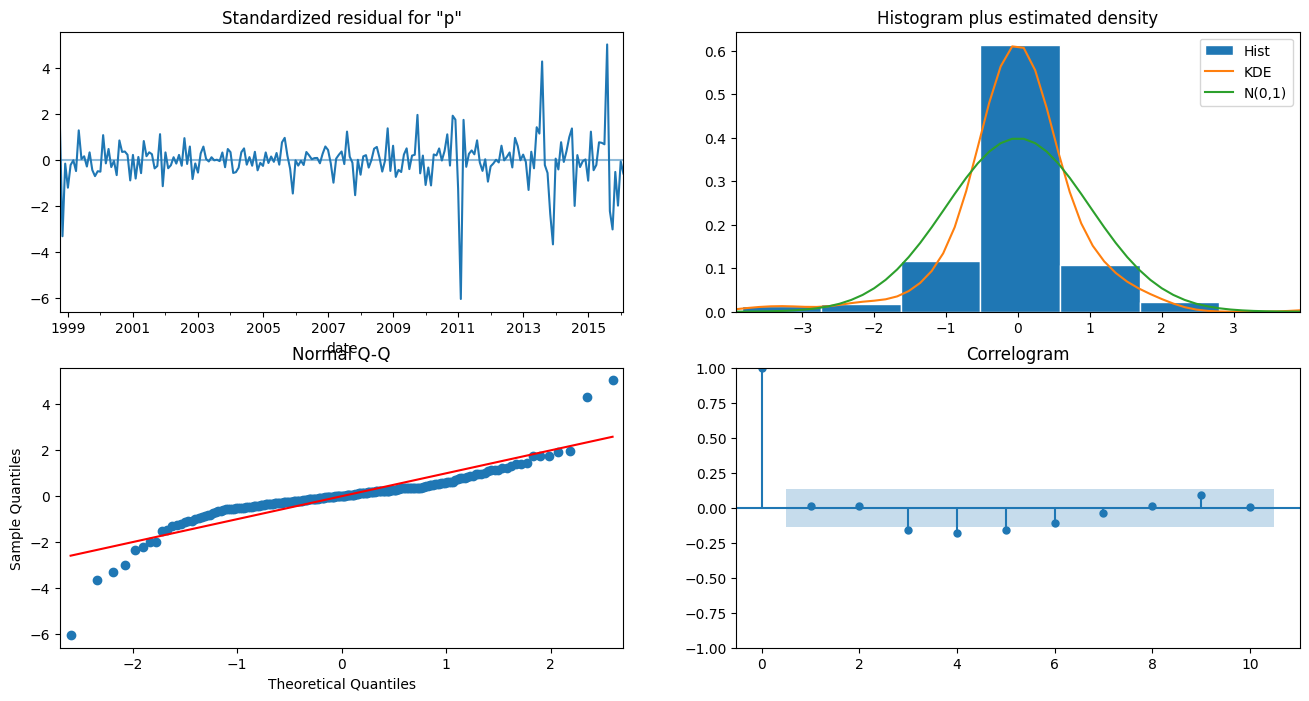

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

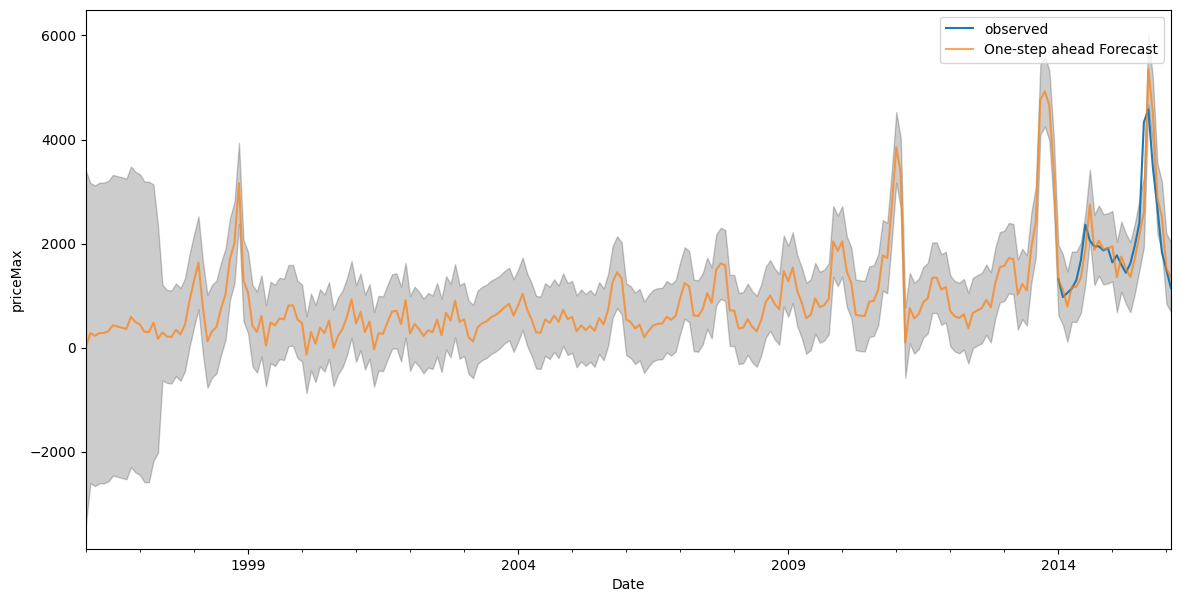

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1996-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('priceMax')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['1996-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 111429.63


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 333.81


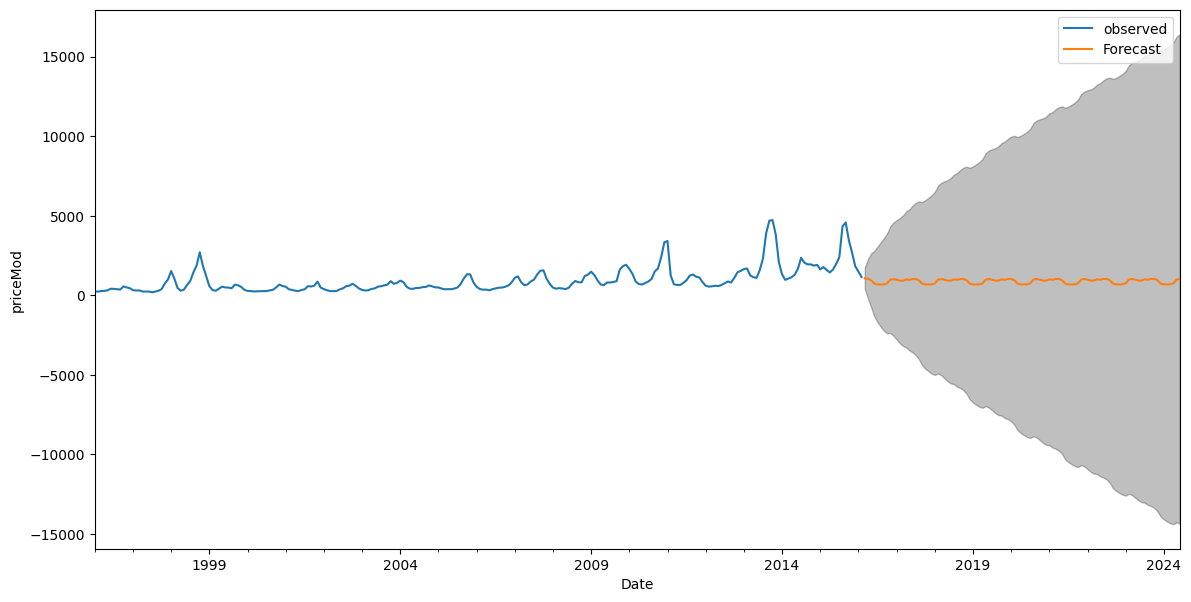

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('priceMax')
plt.legend()
plt.show()

#priceMod

In [ ]:
y = data['priceMod'].resample('MS').mean()

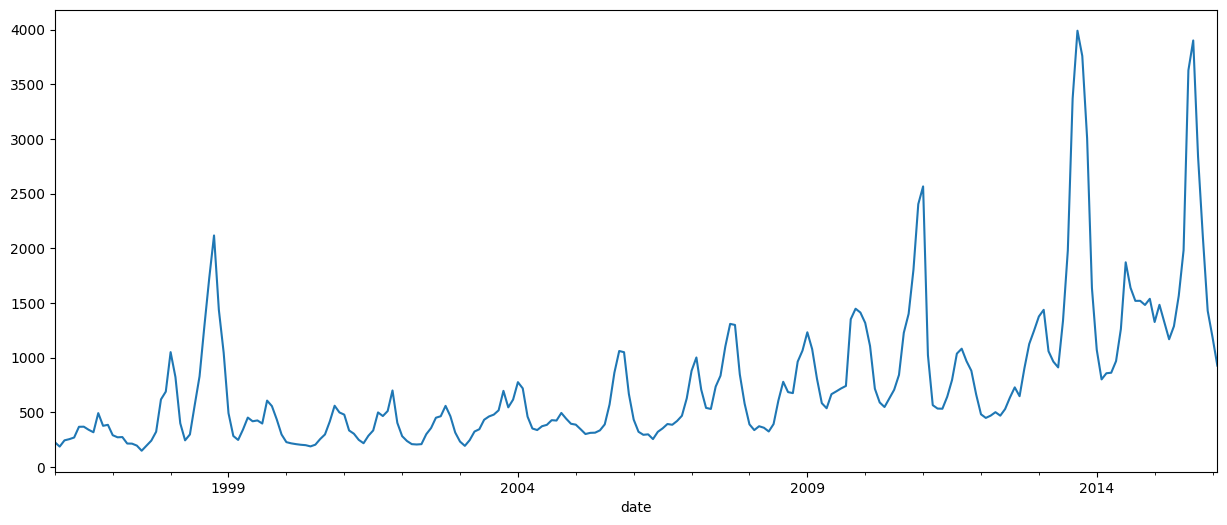

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

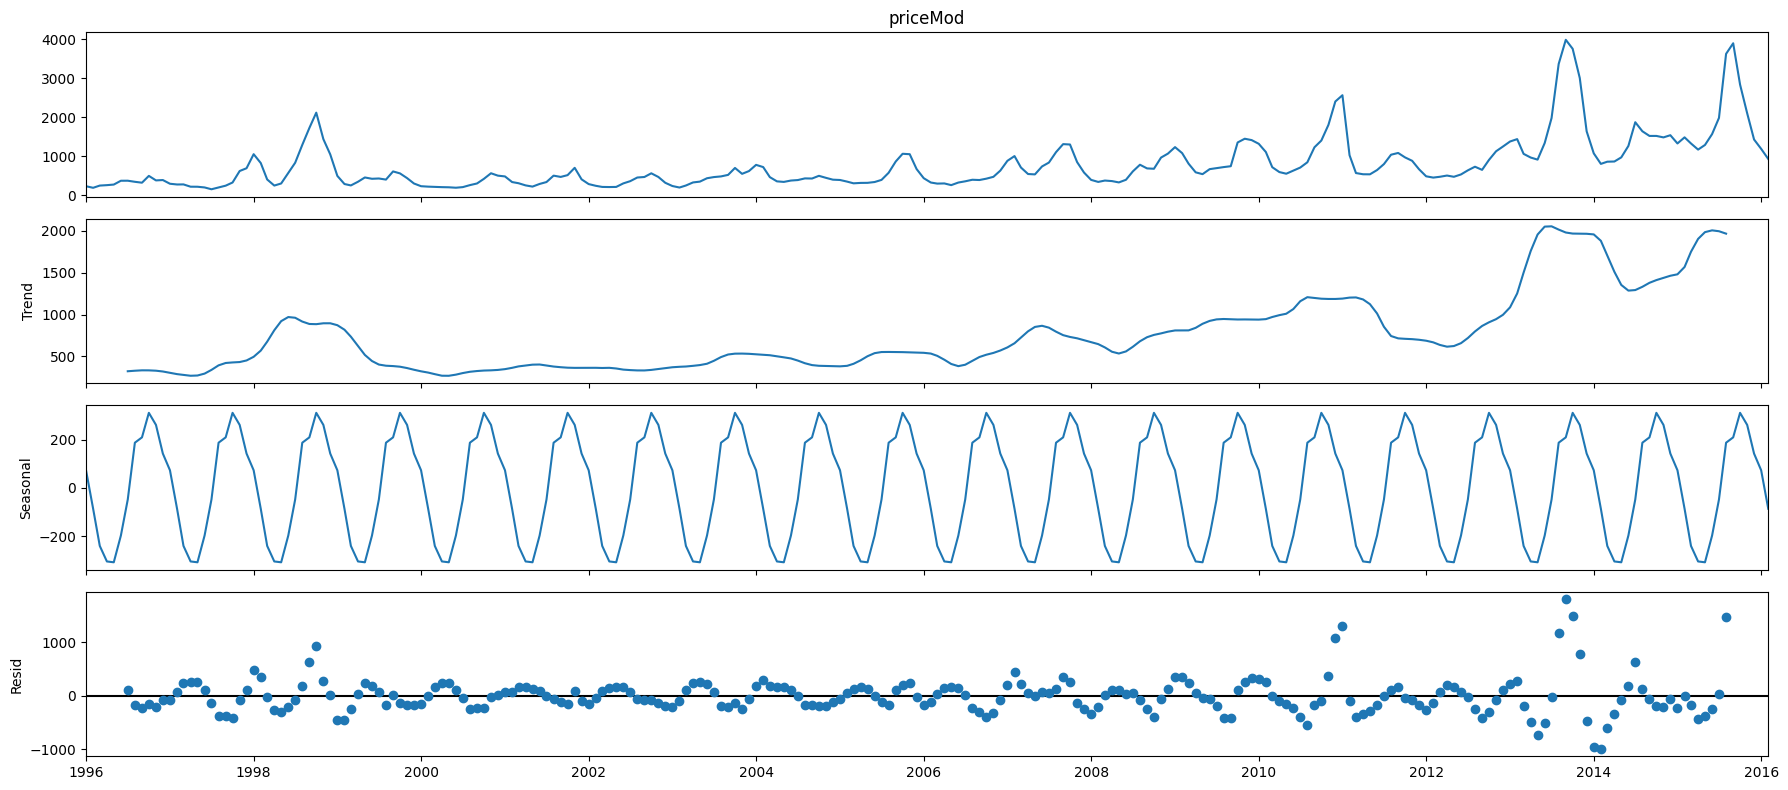

In [ ]:

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4022.9705236045165
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3758.8207346920403
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3639.422542690125
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3369.3261717394757
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3648.8387262242145
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3509.549059870964
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3368.3149004536717
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3347.0036820671576
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3719.2673012611313
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3487.5486780462234
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3425.6347629317597
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3151.354251665185
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3438.3257752283034
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3290.6895684003302
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3171.933770578766
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3130.7794695287
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3409.2400086977204
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3251.809090410974


In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1312      0.095      1.384      0.166      -0.055       0.317
ma.L1          0.4066      0.097      4.195      0.000       0.217       0.597
ar.S.L12      -0.3910      0.056     -7.007      0.000      -0.500      -0.282
ma.S.L12      -0.7634      0.053    -14.441      0.000      -0.867      -0.660
sigma2      6.038e+04   2952.323     20.453      0.000    5.46e+04    6.62e+04


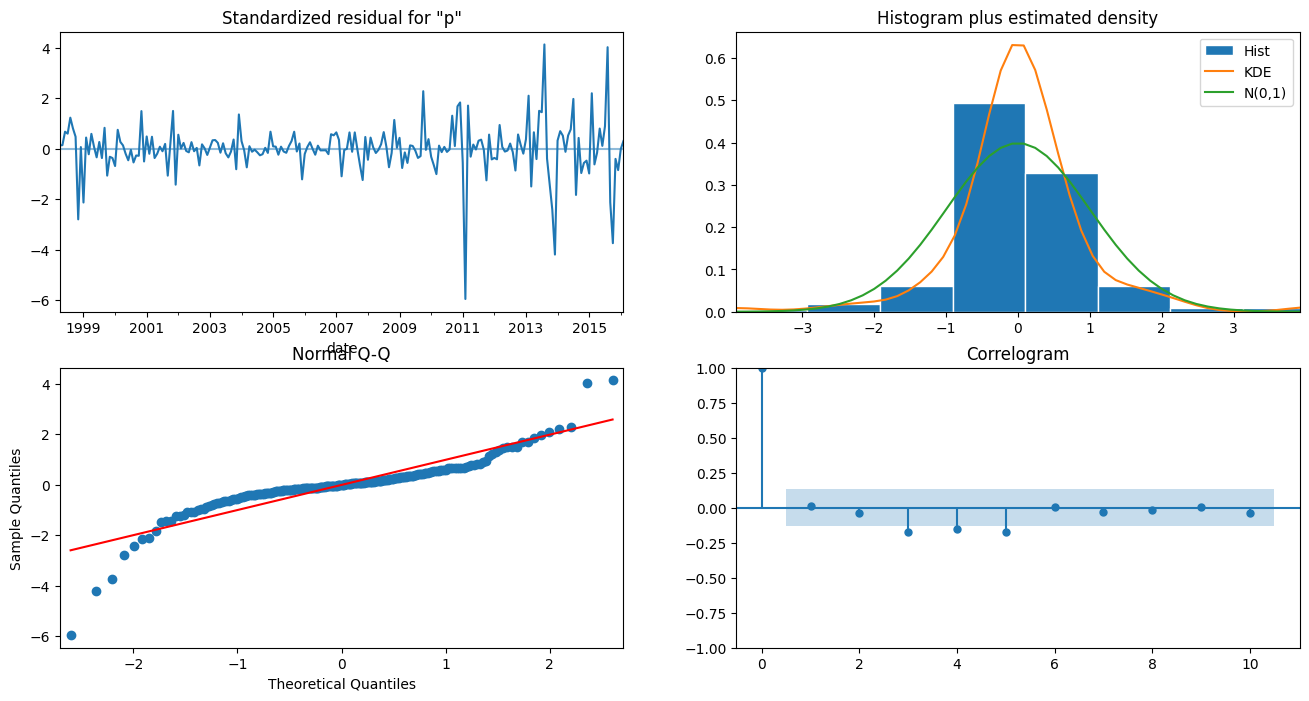

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

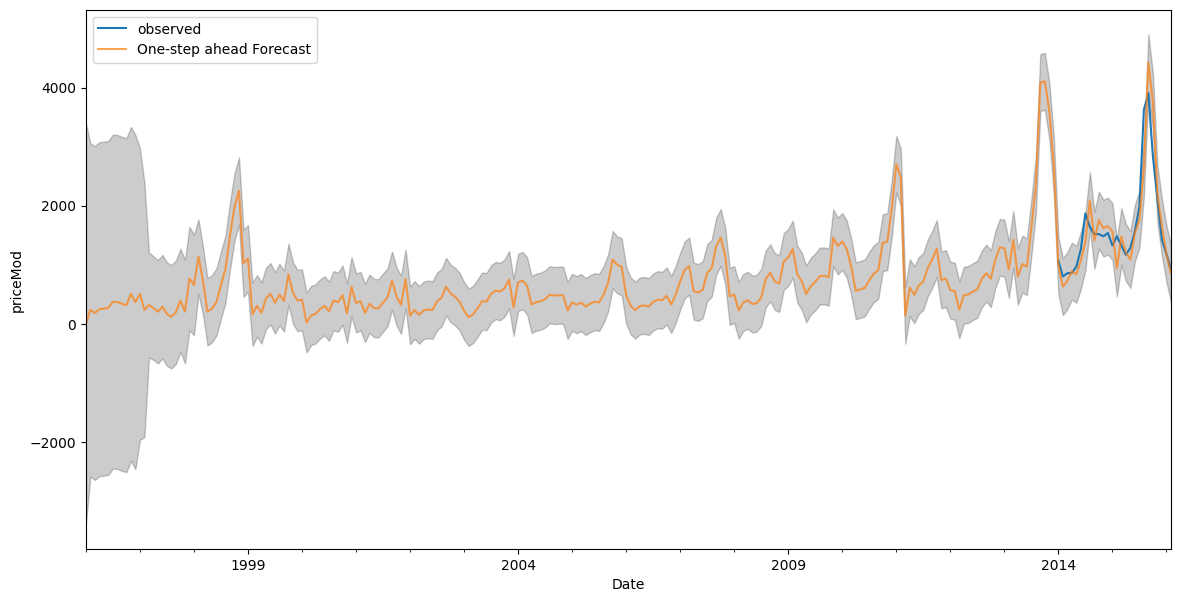

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1996-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('priceMod')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['1996-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 58118.12


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 241.08


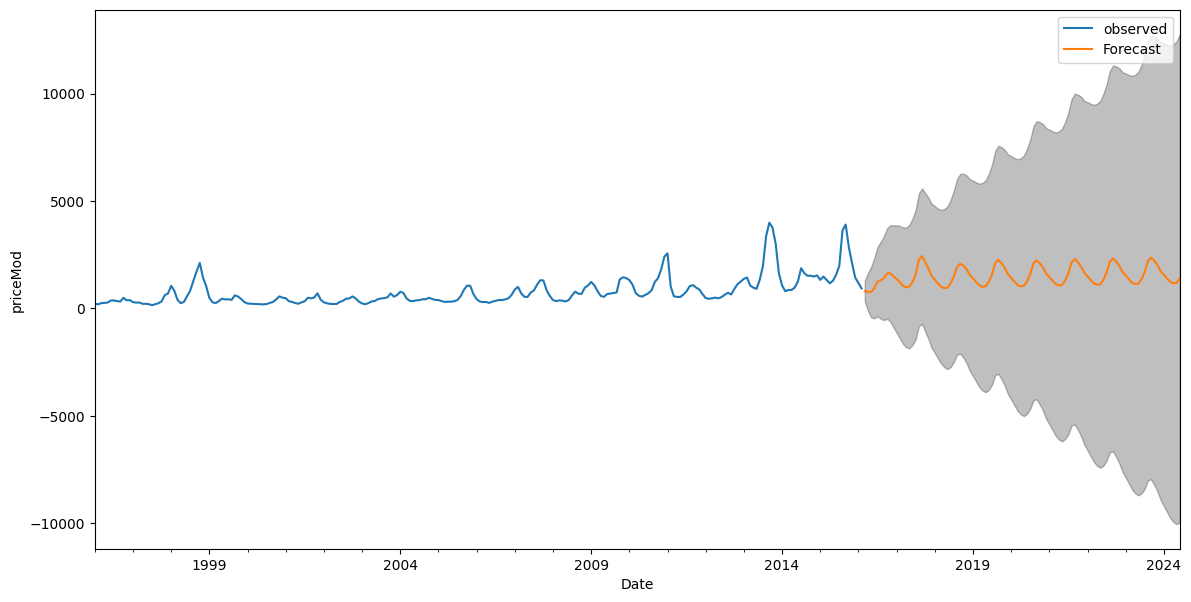

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('priceMod')
plt.legend()
plt.show()